# Intro

This notebook plots the results generated by ```time_resolved_decoding.py``` code, which is the time resolved decoding results for all the sessions.

---
# Setup

In [1]:
##% imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

import seaborn as sns
import xarray as xr

from popy.decoding.decoder_plotting import show_population_decoder_results, show_single_session_decoder, show_prop_signif_units
from popy.decoding.decoder_tools import mask_N_consecutives
from popy.plotting.plot_cortical_grid import get_grid_location, init_location_grid, plot_matrix
from popy.plotting.plotting_tools import plot_keypoints

import popy.config as cfg
PATH = cfg.PROJECT_PATH_LOCAL
import os

In [2]:
##% data tools
def remove_outliers_zscore(df, columns, threshold=5):
    z_scores = np.abs((df[columns] - df[columns].mean()) / df[columns].std())
    return df[(z_scores < threshold).all(axis=1)]

def load_decoding_res(monkey, folder='basics'):
    xr_res = xr.open_dataset(os.path.join(PATH, 'notebooks', 'decoders', 'population_decoding', 'results', folder, f'{monkey}_decoding_results.nc'))
    xr_res.load()
    
    # remove nans along 'session' dimension
    #xr_res = xr_res.dropna('session')
    
    return xr_res

def mask_nonsignificant(res, plim=.05):
    # Iterate through the 3rd dimension and check for neighboring True values
    mask = res.pvals <= plim

    '''for i in range(mask.shape[2]):
        if i == 0:
            # For the first slice, check only the next slice
            mask[:, :, i, :] &= mask[:, :, i + 1, :]
        elif i == mask.shape[2] - 1:
            # For the last slice, check only the previous slice
            mask[:, :, i, :] &= mask[:, :, i - 1, :]
        else:
            # For all other slices, check both the previous and next slices
            mask[:, :, i, :] &= (mask[:, :, i - 1, :] | mask[:, :, i + 1, :])'''

    #res['scores'] = res.scores.where(mask)
    return mask

In [3]:
##% plotting
def plot_identity(res_1, res_2, labels=None, lim=None, title=None):
    # plot heatmap
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 2], width_ratios=[2, 2])
    
    areas = ['LPFC', 'MCC']
    colors = {'LPFC': 'tab:blue', 'MCC': 'grey'}

    for i in range(2):
        # select area
        matrix_1_temp = res_1.sel(area=areas[i])  # select area
        matrix_2_temp = res_2.sel(area=areas[i])  # select area

        # convert to dataframe and merge
        df_1_temp = matrix_1_temp.to_dataframe().reset_index()  # convert to dataframe
        df_2_temp = matrix_2_temp.to_dataframe().reset_index()  # convert to dataframe
        df_temp = pd.merge(df_1_temp, df_2_temp, on=['session', 'time'], suffixes=('_1', '_2'))
        df_temp = df_temp.dropna(subset=['scores_1', 'scores_2'])
        # remove outliers (i.e. values that are too far from the mean)
        #df_temp = remove_outliers_zscore(df_temp, ['scores_q', 'scores_val'])
        #df_temp = df_temp.loc[(df_temp['scores_1'] > 0) & (df_temp['scores_2'] > 0)]  # remove negative values

        # scatter plot 'score_1' vs 'score_2'
        X = df_temp[['scores_1', 'scores_2']].values

        # define identity line and fit line
        a, b = 1.0, 0.0  # slope, intercept
        a_, b_ = np.polyfit(X[:, 0], X[:, 1], 1)

        # projection on normal vector of identity line
        linepoint = np.array([0.0, b])
        normal_vector = np.array([a, -1.0])
        normal_vector /= np.linalg.norm(normal_vector)
        projection = np.dot(X - linepoint, normal_vector)  # projection on normal vector

        # scatter plot 'score_1' vs 'score_2'
        ax1 = plt.subplot(gs[i, 0])
        ax1.scatter(df_temp['scores_1'], df_temp['scores_2'], alpha=.5, color=colors[areas[i]], s=1)
        # Plot the lines
        x_line = np.linspace(np.min([X[:, 0].min(), X[:, 1].min()]), np.max([X[:, 0].max(), X[:, 1].max()]), 10)
        y_line_identity = a * x_line + b
        y_line_fit = a_ * x_line + b_
        ax1.plot(x_line, y_line_identity, 'tab:red', label='Identity line')
        #ax1.plot(x_line, y_line_fit, 'g-', label='Line of best fit')
    
        ax1.axhline(0, color='black', linewidth=.5)
        ax1.axvline(0, color='black', linewidth=.5)

        # x and y span are the same
        if lim is not None:
            ax1.set_xlim(lim)
            ax1.set_ylim(lim)
        else:
            ax1.set_xlim([np.min([X[:, 0].min(), X[:, 1].min()]), np.max([X[:, 0].max(), X[:, 1].max()])])
            ax1.set_ylim([np.min([X[:, 0].min(), X[:, 1].min()]), np.max([X[:, 0].max(), X[:, 1].max()])])
        
        ax1.set_xlabel(f'{labels[0]} value coding (R2)')
        ax1.set_ylabel(f'{labels[1]} value coding (R2)')

        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.grid(alpha=.5)
        ax1.set_title(areas[i])
        ax1.legend()

        # histogram of projection
        ax2 = plt.subplot(gs[i, 1])
        if lim is not None:
            bins = np.linspace(lim[0], lim[1], 11)
        else:
            bins = np.linspace(-np.max(np.abs(projection)), np.max(np.abs(projection)), 11)
        ax2.hist(projection, bins=bins, alpha=.5, linewidth=1, edgecolor='black', color=colors[areas[i]])
        ax2.axvline(0, color='red', linewidth=1, label='Identity line')
        ax2.set_xlabel(f'Distance from identity line\n<-- {labels[1]} better | {labels[0]} better -->')
        ax2.set_ylabel('Count')
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.grid(alpha=.5)
        ax2.set_title(areas[i])
        ax2.legend()

    if title is not None:
        plt.suptitle(title)

    plt.tight_layout()

    plt.show()

def plot_pop_coding(res, mask, title=None, vmin=0, vmax=1, ax=None, n_extra_trials=(-1, 1), x_lim=None):
    # plot heatmap
    if ax is None:
        fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    areas = ['LPFC', 'MCC']

    for i, ax in enumerate(axs):
        matrix_temp = res.sel(area=areas[i])

        # fill nan with -100
        matrix_temp = matrix_temp.fillna(-100)
        im = ax.imshow(matrix_temp, origin='lower', aspect='auto', cmap='cividis',
                        extent=[res.time[0], res.time[-1], -.5, res.shape[0]-.5], 
                        vmin=vmin, vmax=vmax, interpolation=None)
        # blank out nans
        #im.set_array(matrix_temp.where(~nans).values.ravel())
        
        # add colorbar
        im = fig.colorbar(im, ax=ax, label='Decoding accuracy (R2 or %correct)')

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('session & count significants')

        ax.set_yticks(np.arange(0, res.shape[0], 1))
        ax.set_yticklabels([f'{i} - {sess}' for i, sess in enumerate(res.session.values)], fontsize=8)

        plot_keypoints(ax, n_extra_trials=n_extra_trials, fontsize=8)
        ax.grid(alpha=.5)

        ax.set_title(areas[i])

        # plot num significant over time
        ax.plot(mask.time, np.sum(mask.sel(area=areas[i]), axis=0), color='red', label='n signif')
        ax.legend()

        if x_lim is not None:
            ax.set_xlim(x_lim)

    if title is not None:
        plt.suptitle(title)

    plt.tight_layout()

    plt.show()

def plot_prop_signif(mask_ka, maks_po, title=None, n_extra_trials=(-1, 1), x_lim=None):
    # plot heatmap
    w = 8*2  # cm
    h = 7*2  # cm
    fig, ax = plt.subplots(1, 1, figsize=(w/2.54, h/2.54))

    areas = ['LPFC', 'MCC']
    colors = {'LPFC': 'tab:blue', 'MCC': 'grey'}
    linestyle = {'ka': '-', 'po': '--'}
    linewidth = {'ka': 1.5, 'po': 1}

    for area in areas:
        # plot num significant over time
        data_ka = np.sum(mask_ka.sel(area=area), axis=0)/len(mask_ka.session)
        data_ka_smooth = np.convolve(data_ka, np.ones(5)/5, mode='same')
        data_po = np.sum(maks_po.sel(area=area), axis=0)/len(maks_po.session)
        data_po_smooth = np.convolve(data_po, np.ones(5)/5, mode='same')
        ax.plot(mask_ka.time, data_ka_smooth, color=colors[area], linestyle=linestyle['ka'], label=f'ka - {area}', linewidth=linewidth['ka'], alpha=.7)
        ax.plot(maks_po.time, data_po_smooth, color=colors[area], linestyle=linestyle['po'], label=f'po - {area}', linewidth=linewidth['po'], alpha=.7)
    ax.legend(ncol=2)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Proportion of significant units')

    plot_keypoints(ax, n_extra_trials=n_extra_trials, fontsize=8)
    ax.grid(axis='x', alpha=.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    '''if title is not None:
        plt.suptitle(title)'''

    if x_lim is not None:
        ax.set_xlim(x_lim)
    

    plt.tight_layout()

    plt.show()

def plot_res_on_grid(res, mask, monkey, t_interest, vmin=None, vmax=None, title=None, bar_title=None):
    # plot on grid
    grid = init_location_grid()

    # set values of the mask to -100
    masked_res = res.where(mask, -100)

    locs_already_used = set()
    for session in res.session.values:
        for area in res.area.values:
            try:
                loc = get_grid_location(monkey, session, area)
                value = masked_res.sel(session=session, area=area).sel(time=t_interest, method='nearest').data
                
                if loc not in locs_already_used:
                    grid.loc[dict(x=loc[0], y=loc[1])] = value
                    locs_already_used.add(loc)
                else:  # use the best value
                    if value > grid.loc[dict(x=loc[0], y=loc[1])]:
                        grid.loc[dict(x=loc[0], y=loc[1])] = value


            except Exception as e:
                print(e)

    plot_matrix(grid, monkey, vmin=vmin, vmax=vmax, title=title, label=bar_title, not_signif_value=-100)

def plot_analysis(target, 
                  plim, 
                  vmin, vmax, 
                  t_interest, 
                  n_extra_trials, 
                  x_lim=None,
                  bar_title=None, 
                  folder_ka='basics', folder_po='basics'):
    
    res_ka = load_decoding_res('ka', folder=folder_ka)
    res_po = load_decoding_res('po', folder=folder_po)

    res_target_ka = res_ka.scores.sel(target=target)
    res_target_po = res_po.scores.sel(target=target)

    mask_ka = mask_nonsignificant(res_ka, plim=plim)
    mask_po = mask_nonsignificant(res_po, plim=plim)

    mask_target_ka = mask_ka.sel(target=target)
    mask_target_po = mask_po.sel(target=target)

    plot_pop_coding(res_target_ka, mask_target_ka, title=f'{target}\nmonkey: ka', vmin=vmin, vmax=vmax, n_extra_trials=n_extra_trials, x_lim=x_lim)
    plot_pop_coding(res_target_po, mask_target_po, title=f'{target}\nmonkey: po', vmin=vmin, vmax=vmax, n_extra_trials=n_extra_trials, x_lim=x_lim)

    plot_prop_signif(mask_target_ka, mask_target_po, title=f'Proportion of significant sessions\n{target}', n_extra_trials=n_extra_trials, x_lim=x_lim)

    plot_res_on_grid(res_target_ka, mask_target_ka, 'ka', t_interest=t_interest, vmin=vmin, vmax=vmax, title=f'{target}\nmonkey: ka, time: {t_interest}s', bar_title=bar_title)
    plot_res_on_grid(res_target_po, mask_target_po, 'po', t_interest=t_interest, vmin=vmin, vmax=vmax, title=f'{target}\nmonkey: po, time: {t_interest}s', bar_title=bar_title)


---
# Section 1: Simple results

Data is in the format of xarrays, as:
...

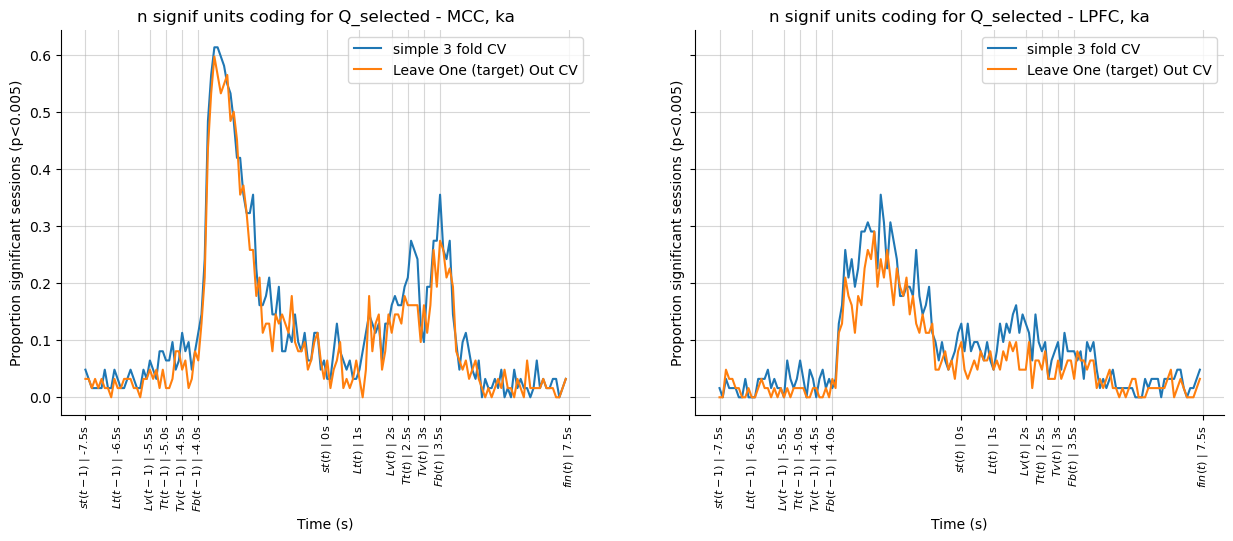

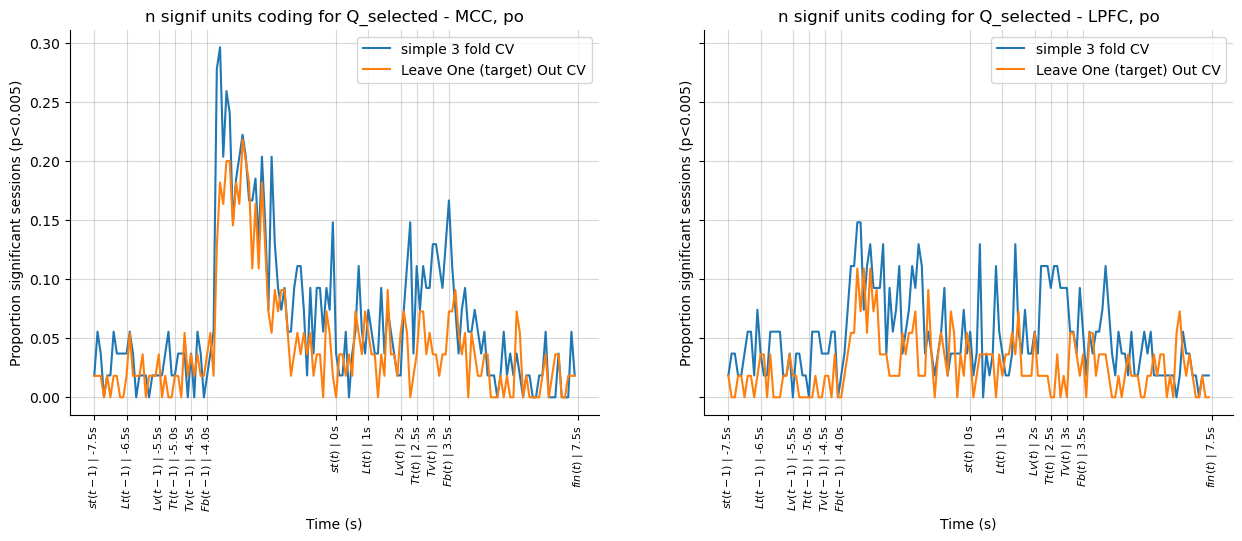

In [4]:
for monkey in ['ka', 'po']:
    res_naive = load_decoding_res(monkey, folder='target_stratified/naive')
    res_informed = load_decoding_res(monkey, folder='target_stratified/informed')
    
    plim = 0.005
    target = 'Q_selected'
        
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

    areas = ['MCC', 'LPFC']

    for i, ax in enumerate(axs):
        pvals_naive = res_naive.sel(target=target, area=areas[i]).pvals.values
        pvals_informed = res_informed.sel(target=target, area=areas[i]).pvals.values

        n_signif_naive = (pvals_naive<plim).mean(axis=0)
        n_signif_informed = (pvals_informed<plim).mean(axis=0)

        ax.plot(res_naive.time, n_signif_naive, label='simple 3 fold CV')
        ax.plot(res_informed.time, n_signif_informed, label='Leave One (target) Out CV')
        #ax.plot(res_informed.time, n_signif_naive - n_signif_informed, label='Difference', color='tab:red', alpha=.5)

        plot_keypoints(ax, n_extra_trials=(-1, 0), fontsize=8)
        ax.grid(alpha=.5)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_xlabel('Time (s)')
        ax.set_ylabel(f'Proportion significant sessions (p<{plim})')
        ax.set_title(f'n signif units coding for {target} - {areas[i]}, {monkey}')

        ax.legend()
    plt.show()



In [5]:
# plot each session for sanity check
'''# plot an example session
for session in res_naive.session.values:

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    for i, ax in enumerate(axs):
        res_naiv_temp = res_naive.sel(session=session, target='Q_selected', area="MCC" if i == 0 else "LPFC")
        res_informed_temp = res_informed.sel(session=session, target='Q_selected', area="MCC" if i == 0 else "LPFC")

        #diff = res_informed_temp.scores - res_naiv_temp.scores

        ax.plot(res_naiv_temp.time, res_naiv_temp.scores, label='naive')
        ax.plot(res_informed_temp.time, res_informed_temp.scores, label='informed')
        ax.axhline(0, color='black', linestyle='--')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('R2')
        ax.legend()
        

        ax.set_title(f'{session} - {"MCC" if i == 0 else "LPFC"}')

    plt.show()
'''

'#\xa0plot an example session\nfor session in res_naive.session.values:\n\n    fig, axs = plt.subplots(1, 2, figsize=(10, 5))\n\n    for i, ax in enumerate(axs):\n        res_naiv_temp = res_naive.sel(session=session, target=\'Q_selected\', area="MCC" if i == 0 else "LPFC")\n        res_informed_temp = res_informed.sel(session=session, target=\'Q_selected\', area="MCC" if i == 0 else "LPFC")\n\n        #diff = res_informed_temp.scores - res_naiv_temp.scores\n\n        ax.plot(res_naiv_temp.time, res_naiv_temp.scores, label=\'naive\')\n        ax.plot(res_informed_temp.time, res_informed_temp.scores, label=\'informed\')\n        ax.axhline(0, color=\'black\', linestyle=\'--\')\n        ax.set_xlabel(\'Time (s)\')\n        ax.set_ylabel(\'R2\')\n        ax.legend()\n        \n\n        ax.set_title(f\'{session} - {"MCC" if i == 0 else "LPFC"}\')\n\n    plt.show()\n'

### Comparing 10-fold CV with Leave One Target Out CV

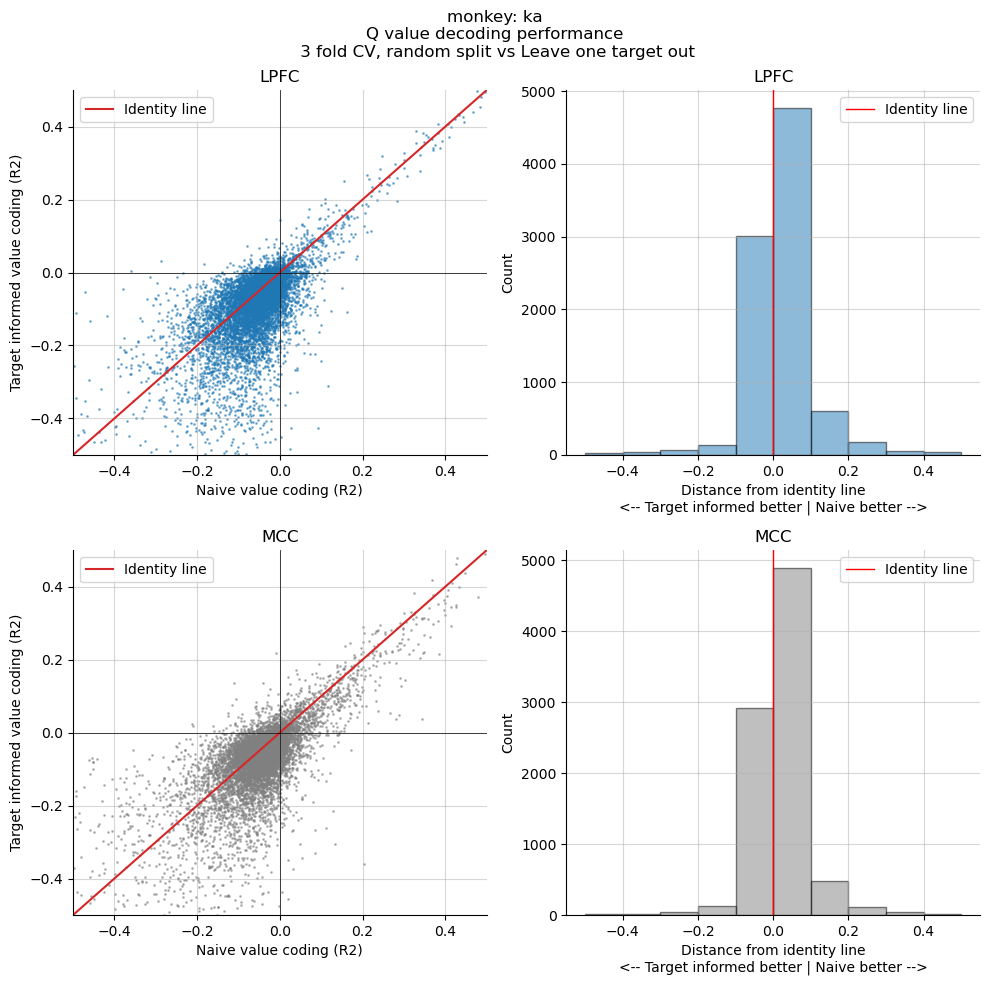

In [20]:
monkey = 'ka'

res_naive = load_decoding_res(monkey, folder='target_stratified/naive')
res_informed = load_decoding_res(monkey, folder='target_stratified/informed')

res_naive_temp = res_naive.scores.sel(target='Q_selected')
res_informed_temp = res_informed.scores.sel(target='Q_selected')


plot_identity(res_naive_temp, res_informed_temp, 
              labels=['Naive', 'Target informed'],
              lim=[-.5, .5],
              title=f'monkey: {monkey}\nQ value decoding performance\n 3 fold CV, random split vs Leave one target out')

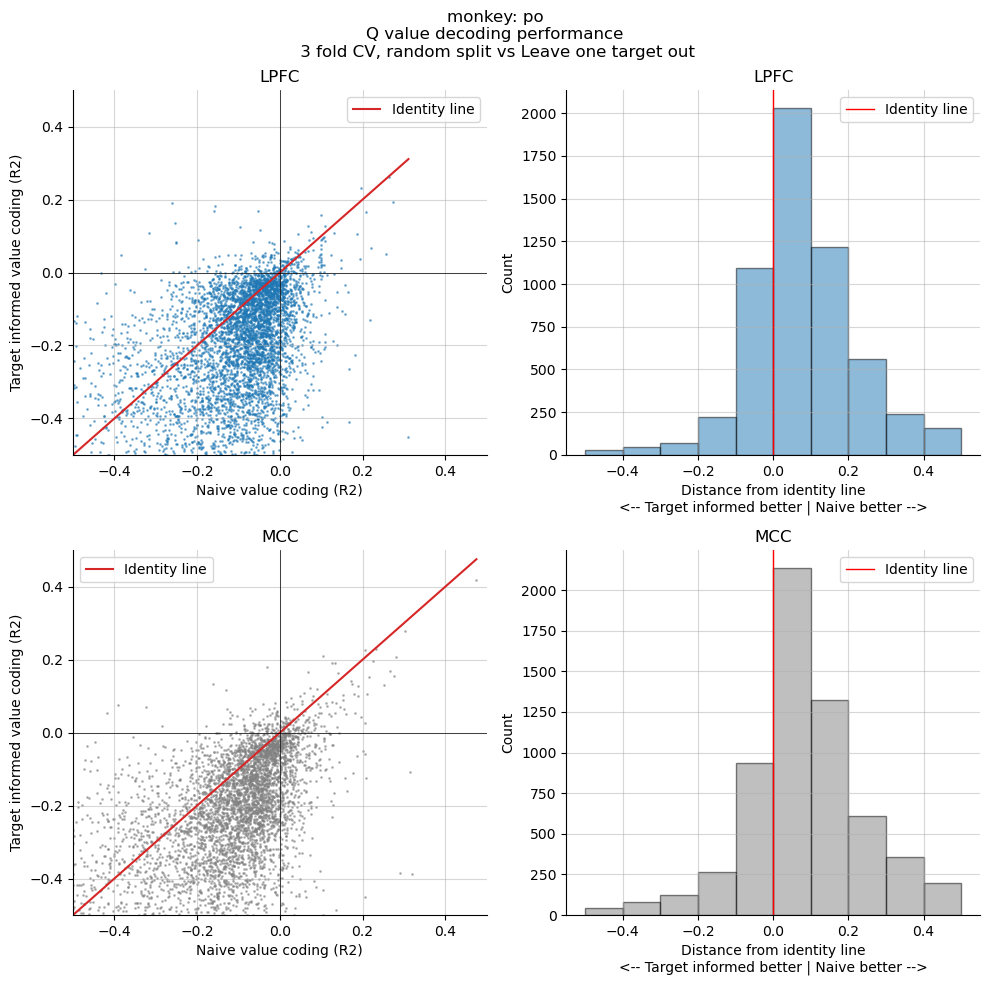

In [21]:
monkey = 'po'

res_naive = load_decoding_res(monkey, folder='target_stratified/naive')
res_informed = load_decoding_res(monkey, folder='target_stratified/informed')

res_naive_temp = res_naive.scores.sel(target='Q_selected')
res_informed_temp = res_informed.scores.sel(target='Q_selected')


plot_identity(res_naive_temp, res_informed_temp, 
              labels=['Naive', 'Target informed'],
              lim=[-.5, .5],
              title=f'monkey: {monkey}\nQ value decoding performance\n 3 fold CV, random split vs Leave one target out')

## Plot the significants, remarking those that are not overlapping

What we want here is to 
- for those sessions which are significant in both cases, we want to plot the difference in coding strenght
- furthermore, we want to plot the sessions which are significant in one but not in the other

'float' object is not subscriptable
Only informed is significative: ka - 150720 - MCC
Only informed is significative: ka - 190620 - MCC
Only naive is significative: ka - 300720 - MCC
Only naive is significative: ka - 270720 - MCC
Only naive is significative: ka - 100820 - LPFC
Only naive is significative: ka - 200820 - MCC
Only naive is significative: ka - 150221 - MCC
Only naive is significative: ka - 180321 - MCC
Only naive is significative: ka - 070322 - LPFC
Only informed is significative: ka - 280322 - MCC
Only naive is significative: ka - 200422 - LPFC
Only naive is significative: ka - 050422 - MCC
Only naive is significative: ka - 130622 - MCC
Only naive is significative: ka - 270722 - MCC
'float' object is not subscriptable
Only informed is significative: po - 090920 - MCC
Only naive is significative: po - 160920 - MCC
Only naive is significative: po - 121020 - MCC
Only informed is significative: po - 141020 - MCC
Only informed is significative: po - 261020 - MCC
Only naive is 

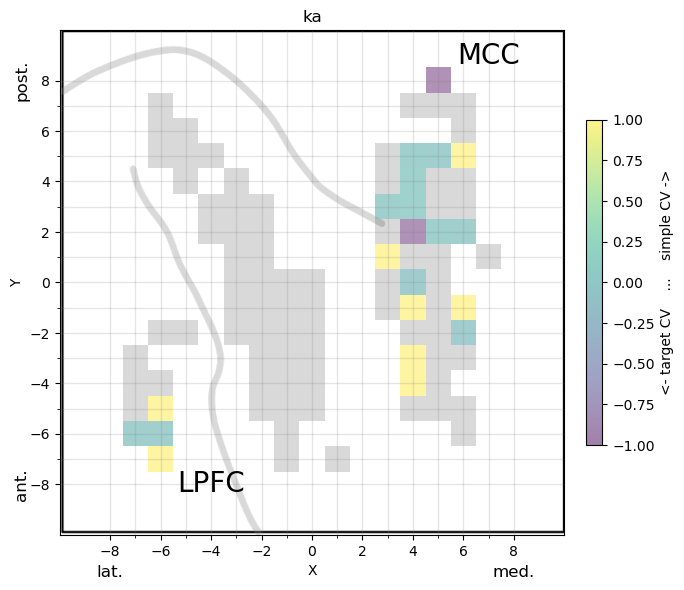

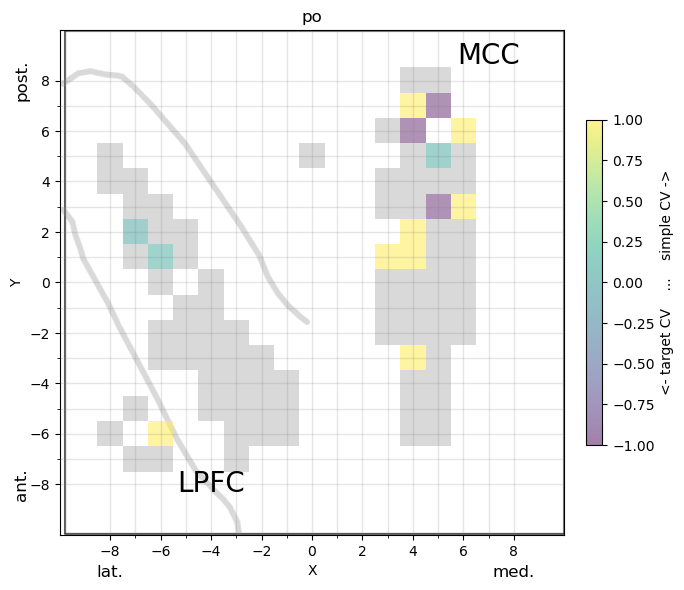

In [12]:
for monkey in ['ka', 'po']:
    # plot on grid
    grid = init_location_grid()

    res_naive = load_decoding_res(monkey, folder='target_stratified/naive')
    res_informed = load_decoding_res(monkey, folder='target_stratified/informed')
    
    plim = 0.005
    target = 'Q_selected'
    t = 3.5

    res_naive_temp = res_naive.sel(target=target, time=t)
    res_informed_temp = res_informed.sel(target=target, time=t)

    for session in res_naive_temp.session.values:
        for area in res_naive_temp.area.values:
            try:
                loc = get_grid_location(monkey, session, area)
                
                signif_naive = res_naive_temp.pvals.sel(session=session, area=area).data < plim
                signif_informed = res_informed_temp.pvals.sel(session=session, area=area).data < plim

                if signif_naive and signif_informed:
                    value_naive = res_naive_temp.scores.sel(session=session, area=area).data
                    value_informed = res_informed_temp.scores.sel(session=session, area=area).data
                    value_to_show = value_naive - value_informed
                    #print(f'Both are significative: {monkey} - {session} - {area}')
                elif signif_naive:
                    value_to_show = 10
                    print(f'Only naive is significative: {monkey} - {session} - {area}')
                elif signif_informed:
                    value_to_show = -10
                    print(f'Only informed is significative: {monkey} - {session} - {area}')
                else:
                    value_to_show = -100

                grid.loc[dict(x=loc[0], y=loc[1])] = value_to_show
                    
            except Exception as e:
                print(e)

    plot_matrix(grid, monkey, vmin=-1, vmax=1, title=f'{monkey}', label='<- target CV    ...    simple CV ->', not_signif_value=-100, cmap='viridis')

In [24]:
t = 3.5


locs_already_used = set()
for session in res.session.values:
    for area in res.area.values:
        try:
            loc = get_grid_location(monkey, session, area)
            value = masked_res.sel(session=session, area=area).sel(time=t_interest, method='nearest').data
            
            if loc not in locs_already_used:
                grid.loc[dict(x=loc[0], y=loc[1])] = value
                locs_already_used.add(loc)
            else:  # use the best value
                if value > grid.loc[dict(x=loc[0], y=loc[1])]:
                    grid.loc[dict(x=loc[0], y=loc[1])] = value

        except Exception as e:
            print(e)

plot_matrix(grid, monkey, vmin=vmin, vmax=vmax, title=title, label=bar_title, not_signif_value=-100)